<a href="https://colab.research.google.com/github/sucrammal/vectari/blob/main/fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Classification and Fine Tuning
This notebook is the summary of all that I've learnt throughout this internship about LLMs, prompting techniques, and experiments with the dataset, combined with my first attempt at fine-tuning.


In [1]:
#@title Imports
!pip install nltk openai ipdb

import pandas as pd
import openai
from openai import AzureOpenAI
from tqdm import tqdm
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import ipdb

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import *

nltk.download('punkt')
nltk.download('stopwords')

from google.colab import drive
drive.mount('/content/drive')
from google.colab import userdata


  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.7/336.7 kB 937.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 737.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 666.0 kB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 622.7 kB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


### Setting up OpenAI API

In [2]:
# Setting up API
gpt_config = {
    'model': 'gpt-4-vectari-1106preview',
    'azure_endpoint': 'https://oai-vectari-eastus2.openai.azure.com/',
    'api_key': userdata.get('openAPIKey'),
    'api_version': '2023-12-01-preview'
}

client = AzureOpenAI(
  azure_endpoint = gpt_config['azure_endpoint'],
  api_key = gpt_config['api_key'],
  api_version = gpt_config['api_version']
)

### Loading in data
In my own trials, I am booting the CFPB Money transfer, virtual currency, or money service dataset, 2011-2024.

In [ ]:
# instantiate input file from scratch. Skip this portion along with the LLM cleaning if you already have a cleaned dataset.
input_file = input("Enter file path of raw dataset")
with open(input_file, 'r') as file:
  all_complaints = pd.read_csv(file)

# extract complaints with transcripts
complaints_with_transcripts = all_complaints.loc[all_complaints["Consumer complaint narrative"].notna()]
complaints_with_transcripts.shape[0]

# Run this to clean transcipts from scratch.
LLM_cleaned_sentences = []
all_labels = complaints_with_transcripts['Issue']

tqdm.pandas(desc="LLM transcript cleaning")
LLM_cleaned_sentences = complaints_with_transcripts["Consumer complaint narrative"].progress_apply(lambda x : clean_transcript(x))

cleaned_dataset = pd.DataFrame({'Consumer complaint narrative': LLM_cleaned_sentences, 'Issue': all_labels})

In [3]:
# OR load LLM pre-cleaned transcripts from csv
input_file = input("Enter a file name that exists in the Data folder: ")
cleaned_dataset = pd.DataFrame()

# /content/drive/MyDrive/Internships and Work/Summer 2024/Vectari/out/LLM_cleaned.csv
with open(input_file, 'r') as file:
    cleaned_dataset = pd.read_csv(file)

Enter a file name that exists in the Data folder: /content/drive/MyDrive/Internships and Work/Summer 2024/Vectari/out/LLM_cleaned.csv


### Using LLM to clean the transcripts.
Here, I am using the CO-STAR prompting framework to organize the instructions of the prompt.

In [ ]:
cleaning_system = """
CONTEXT: You will receive a transcript of a phone call between a call center agent at a digital payments servicing company and a customer/borrower. You need to clean this transcript.

#############

OBJECTIVE: Your first job is to clean the incoming low-quality transcripts from the first dataset. These are calls about financial services and we have seen some text completely out of place.  For instance 'the first drug was fixed, and any drug after that was gonna be viral' should pretty clearly be
'the first rate was fixed, and any rate after that was going to be variable'.
1. Your job is to parse the text and using your natural language understanding and contextual awareness, please re-write the transcript and clean any grammar / things that do not make sense in financial use cases.
2. Additionally, remove any unwanted 'x's, 'xxxx's, any other similar phrases representing redaction, and simply any text or numbers that aren't words.
3. Remove any dates, names, and otherwise sensitive information.
4. After the response is generated, remove all full stops, commas, semicolons, colons, and quotation marks.

#############

# STYLE #
Financial complaint transcript

#############

# TONE #
Professional, technical

#############

# AUDIENCE #
Banks. I want accurate classification so that they will adopt this methodology to help organize their complaints database.

#############

# RESPONSE: A PARAGRAPH OF TEXT #
"""

In [ ]:
def clean_transcript(transcript):
  messages = [
    {
        "role":"system",
        "content": cleaning_system
    },
    {
        "role":"user",
        "content":f'"""{transcript}"""'
    }
  ]

  response = client.chat.completions.create(
      model=gpt_config['model'],
      messages = messages,
      temperature = 0,
      top_p = 0.2
  )

  LLM_cleaned_sample = response.choices[0].message.content
  return LLM_cleaned_sample

### Analyzing and "learning" from complaint clusters.
Using the LLM's natural language comprehension ability, I am asking the LLM to come up with its own "cluster report" - it's own analysis and summary of each group of complaint transcripts. Once again, I am using the CO-STAR framework. The most important part of the prompt in my experience is being clear about the format of the input.

Somewhat like a RAG model of sorts, this is similar to building a "knowledge base" for the LLM by feeding in labeled data, asking it to summarize and pull out key words from transcripts of each category. The hope is that when I prompt it with a lone, unlabeled transcript, it will be able to reference this knowledge base and retrieve those relevant keywords.

In [ ]:
cluster_system = """
CONTEXT: You will now be recieving a large text containing transcripts of phone calls between a call center agent at a digital payments servicing company and a customer/borrower. This large text represents a CLUSTER of transcripts that have been categorized based on content under some label, for example, "fraud or scam".
This label, referred to as the [OFFICIAL_CATEGORY_NAME], will be at the top of the prompt before the transcripts.
Following the [OFFICIAL_CATEGORY_NAME], there will be a newline character, then individual transcripts will be consecutively shown, separated by two newline characters from one another.

#############

OBJECTIVE:
Based on the cluster you have received,
OFFICIAL CATEGORY NAME: Restate the OFFICIAL_CATEGORY_NAME given on the top of the prompt.
CLUSTER_INFORMATION: Describe the cluster based on the content of the transcript data.

#############

STYLE:
Business analytics report

#############

TONE:
Professional, technical

#############

AUDIENCE:
Banks. I want to help organize their complaints database.

#############

RESPONSE: MARKDOWN REPORT FORMATED IN THE FOLLOWING STYLE:
– Offical name: [OFFICIAL_CATEGORY_NAME]
— Complaint Group Profile: [CLUSTER_INFORMATION]

"""

In [ ]:
def cluster_complaints(cleaned_dataset):
    clusters = cleaned_dataset.groupby('Issue')
    cluster_info = {}

    for label, group in tqdm(clusters, desc="Creating clusters"):
        # Collect all transcripts in this cluster
        transcripts = group['Consumer complaint narrative'].tolist()

        # Weird error. Passing the full, unsplit dataset through this function worked.
        # But, passing a train set (from train_test_split) would crash since a value in transcripts would somehow not be a string.
        filtered_list = [s for s in transcripts if isinstance(s, str)]

        # Extract keywords and name cluster group.
        all_transcripts_joined = "\n\n".join(filtered_list)
        messages = [
          {
              "role":"system",
              "content": cluster_system
          },
          {
              "role":"user",
              "content":f'""" Official name: {label} \n Transcrips: \n {all_transcripts_joined}"""'
          }
        ]

        response = client.chat.completions.create(
            model=gpt_config['model'],
            messages = messages,
            temperature = 0,
            top_p = 0.2
        )

        cluster_report = response.choices[0].message.content


        cluster_info[label] = cluster_report

    return cluster_info

### Finally, a classification function
After "learning" through analyzing labeled, example transcripts, we now see if the LLM can label an uncategorized transcript correctly. I am using 2 different prompting methods: CO-STAR, and TIDD-EC, which compared with the former, focuses on the precision and clarity of instructions rather than context, audience, and tone. This classification task might benefit from the TIDD-EC framework

**CO-STAR prompt and function implementation**

In [ ]:
classify_system_COSTAR = """
CONTEXT: You have previously created Complaint Groups of transcripts of complaint phone calls between a call center agent at a digital payments servicing company and a customer/borrower based
on the category of the complaints. Transcripts under each Complaint Group has been categorized based on content under some label, for example, "fraud or scam".

You will now be recieving three things: the first is a set of markdown reports representing the information you have gathered and organized for each CLUSTER, and are of the following format:
"– Offical name: [OFFICIAL_CATEGORY_NAME]
— Complaint Group Profile: [CLUSTER_INFORMATION]"
Each markdown report for each Complaint Group will be separated by a new line character, "\n".

The second piece of data you will receive is a transcript that has not been categorized into one of your CLUSTERs yet.

The third piece of data you will receive is a comma-separated list of [OFFICIAL_CATEGORY_NAME]'s, representing all possible categories that the aformentioned transcript can belong to.

#############

OBJECTIVE: Based on your natural language understanding, and your understanding of the cluster markdown reports, determine which [OFFICIAL_CATEGORY_NAME] from the list, the incoming transcript belongs under.

#############

STYLE: Business analytics report

#############

TONE: Professional, technical

#############

AUDIENCE: Banks. I want accurate classification so that they will adopt this methodology to help organize their complaints database.

#############

# RESPONSE: Single line of text containing ONLY one [OFFICIAL_CATEGORY_NAME] of your choosing from the comma-separated category name list: #
[OFFICIAL_CATEGORY_NAME]
"""

In [ ]:
def classify_transcript_COSTAR(cluster_info, new_transcript):
  # unpack official label names,
  labels = cluster_info.keys()

  # Join the keys into a string separated by commas
  labels_string = ', '.join(labels)

  # unpack and format cluster_info, aka the reports
  markdown_reports = ""

  for report in cluster_info.values():
    markdown_reports = "\n".join(report)

  messages = [
          {
              "role":"system",
              "content": classify_system_COSTAR
          },
          {
              "role":"user",
              "content":f'"""Cluster markdown reports: \n {markdown_reports} \n Transcript to-be classified: \n {new_transcript} \n Category list: \n {labels_string}"""'
          }
        ]

  response = client.chat.completions.create(
            model=gpt_config['model'],
            messages = messages,
            temperature = 0,
            top_p = 0.2
        )

  complaint_label = response.choices[0].message.content

  return complaint_label


**TIDD-EC prompt and function implementation**

In [ ]:
def generate_TIDDER_prompt(cluster_info, category_list):

  classify_system_TIDDER = """

  TASK TYPE:
  You are a compliance analyst, tasked with the job of classifying incoming complaint transcripts of phone calls between a call center agent at a digital payments servicing company and a customer/borrower
  under a specific set of categories, based on a cluster report that you have previously made. This cluster report details the specific characteristics of each type of complaint category.

  #############

  INSTRUCTIONS:
  You will now be recieving three things: the first is the cluster report, containing the information you have gathered and organized for each complaint category, and are of the following format:
  – Offical name: [OFFICIAL_CATEGORY_NAME]
  — Complaint Group Profile: [CLUSTER_INFORMATION]
  Each markdown report for each complaint category will be separated by a new line character, "\n".

  The second piece of data you will receive is a comma-separated list of [OFFICIAL_CATEGORY_NAME]'s, representing all possible categories that the aformentioned transcript can belong to.

  These pieces of data will be available in the USER CONTENT section of this prompt.

  The last piece of data you will receive is a transcript that has not been categorized into one of your CLUSTERs yet.

  Based on your natural language understanding, and your understanding of the cluster markdown reports, determine which [OFFICIAL_CATEGORY_NAME] from the list, the incoming transcript belongs under.
  Your response should be a single line of text containing ONLY one [OFFICIAL_CATEGORY_NAME] of your choosing from the comma-separated category name list.

  #############

  DO:
  - Parse through the cluster report in its entirety, picking up key words that are characteristic to each complaint category.
  - Only pick ONLY ONE [OFFICIAL_CATEGORY_NAME] of your choosing from the comma-separated category name list.

  #############

  DON'T:
  – Produce your own category name to label the incoming lone transcript.

  #############

  EXAMPLE:

  - Sample input:
  I am a citizen living presently in [Country Name].
  I received a phone call about an attractive sales offer for a diamond priced at $5700. However, I soon realized that it was a scam because the seller told me that he already had a buyer for the diamond. This made me suspicious because if it was a legitimate sale, he wouldn't continue to sell it when he could get more for it elsewhere. I tried to verify the seller's address but couldn't find any specifics to confirm. He claimed to be located in [City Name] but I couldn't verify the details.
  I requested to cancel the sale and receive a refund for the money I had already sent via PayPal. The seller made me believe that I would be refunded and mentioned that the treasurer would contact me for my bank details. However, as time passed, I realized that there would be no refund.
  When I filed a dispute with PayPal, the seller mentioned that the deadline for retraction had expired and that I should have sent a registered letter to the [City Name] office. It was then that I found out the address of the office in [City Name], but I have doubts about its legitimacy. The office is a small storefront on a back street.
  Please note that a sales contract by telephone in [Country Name] is not valid without a written and signed contract presented by the seller to the buyer. I never received a detailed contract from him and I didn't even know his address and sales conditions until it was too late. I haven't received the diamond and I don't want it. I just want my money back that PayPal advanced to the buyer, which amounts to $1500.
  Additionally, when I logged onto the seller's website, I changed my password for my usual one, unfortunately the same password I use for my PayPal access. Shortly after, PayPal notified me that my account had been breached from an unknown location. I immediately changed my PayPal password. Although I have no evidence that the seller is responsible, it seems very suspicious.

  - Resulting output:
  Fraud or scam

  #############

  USER CONTENT:
  """ + f"{cluster_info} \n {category_list}"

  return classify_system_TIDDER

In [ ]:
def classify_transcript_TIDDEC(cluster_info, new_transcript):
  # unpack official label names,
  labels = cluster_info.keys()

  # Join the keys into a string separated by commas
  labels_string = ', '.join(labels)

  # unpack and format cluster_info, aka the reports
  markdown_reports = ""

  for report in cluster_info.values():
    markdown_reports = "\n".join(report)

  messages = [
          {
              "role":"system",
              "content": generate_TIDDER_prompt(markdown_reports, labels_string)
          },
          {
              "role":"user",
              "content":f'""" Transcript to-be classified: \n {new_transcript} """'
          }
        ]

  response = client.chat.completions.create(
            model=gpt_config['model'],
            messages = messages,
            temperature = 0,
            top_p = 0.2
        )

  complaint_label = response.choices[0].message.content

  return complaint_label


### Now, let's run the above code!

In [ ]:
train_dataset, test_dataset = train_test_split(cleaned_dataset, random_state=104, test_size=0.20, shuffle = True)

In [ ]:
# Generate the cluster report
cluster_info = cluster_complaints(train_dataset)
print(cluster_info.keys())

Creating clusters: 100%|██████████| 6/6 [03:08<00:00, 31.36s/it]

dict_keys(['Fraud or scam', 'Incorrect/missing disclosures or info', 'Money was not available when promised', 'Other service issues', 'Other transaction issues', 'Wrong amount charged or received'])


In [ ]:
# Optional: export cluster data to a file.
import json

# Convert dictionary to a string
dict_string = json.dumps(cluster_info, indent=4)

# Write the string to a file
with open('cluster_info.txt', 'w') as file:
    file.write(dict_string)

# NOTE: Adjust the file path to your liking!
!cp cluster_info.txt "/content/drive/MyDrive/Internships and Work/Summer 2024/Vectari/out"

Now, let's classify. First, let's use the CO-STAR framework.

In [ ]:
predicted_labels_COSTAR = []
for transcript in tqdm(test_dataset['Consumer complaint narrative'], desc="Predicting labels"):
    predicted_labels_COSTAR.append(classify_transcript_COSTAR(cluster_info, transcript))

Predicting labels:  99%|█████████▉| 1059/1071 [1:40:12<00:23,  1.95s/it]

Then, classify with TIDD-EC

In [ ]:
predicted_labels_TIDDEC = []
for transcript in tqdm(test_dataset['Consumer complaint narrative'], desc="Predicting labels"):
    predicted_labels_TIDDEC.append(classify_transcript_COSTAR(cluster_info, transcript))

In [ ]:
# And, generate classification report
test_labels = test_dataset['Issue'].tolist()

# Evaluation for CO-STAR
COSTAR_report = "Accuracy for CO-STAR classifier:" + accuracy_score(test_labels, predicted_labels_COSTAR) + "\nClassification Report:\n" + classification_report(test_labels, predicted_labels_COSTAR)
print(COSTAR_report)

# Evaluation for TIDD-EC
TIDDEC_report = "Accuracy for TIDD-EC classifier:" + accuracy_score(test_labels, predicted_labels_TIDDEC) + "\nClassification Report:\n" + classification_report(test_labels, predicted_labels_TIDDEC)
print(TIDDEC_report)


In [ ]:
# Optional: export cluster data to a file.
import json

# Convert dictionary to a string
report_string = COSTAR_report + "\n\n" + TIDDEC_report

# Write the string to a file
with open('classifier_report.txt', 'w') as file:
    file.write(report_string)

# NOTE: Adjust the file path.
!cp cluster_info.txt "/content/drive/MyDrive/Internships and Work/Summer 2024/Vectari/out"

# Analyzing results

**CO-STAR vs. TIDD-EC:**

As expected, the TIDD-EC classifier performed slightly better than the CO-STAR prompt (in terms of overall accuracy).
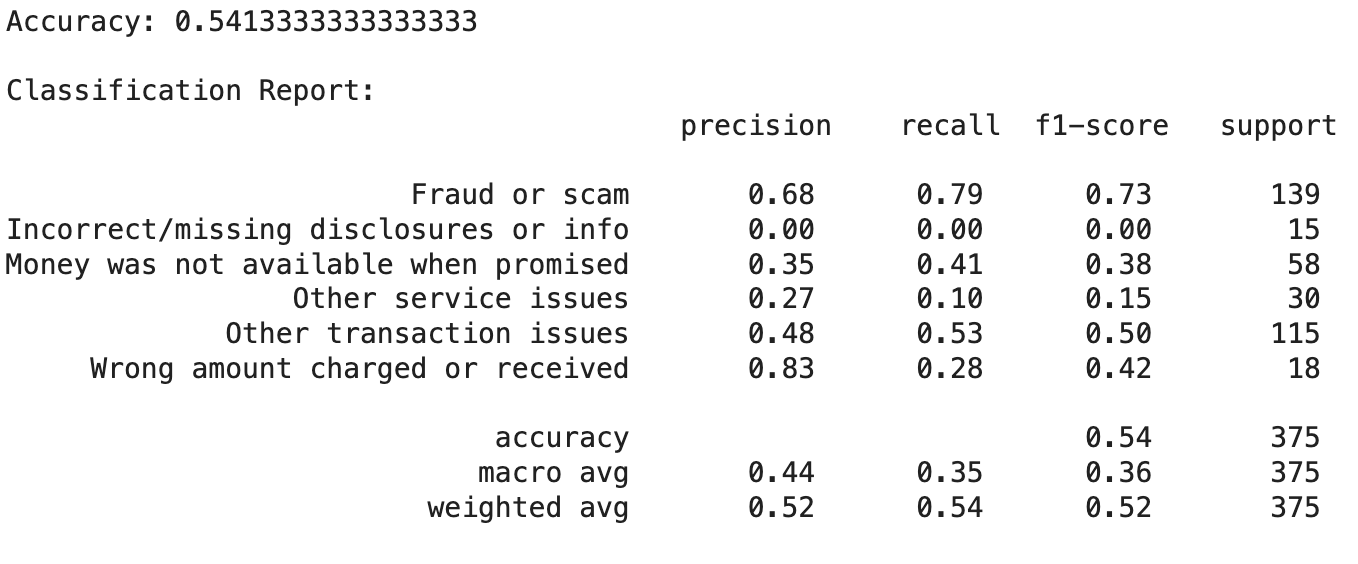

Given the different types of input data, and the specific requirements of the output, a "do"s and "don't"s framework seems to do better.


**Dataset quality, distinctiveness of language, and class balance:**

In general, though, these prompting classifiers still performs laughably bad. Throughout my previous proof-of-concepts, it was very clear that, in part, this poor performance could be attributed to the "noise" of the dataset I used, and of many other CFPB datasets. For example, the LLM is able to accurately identify "fraud or scam" complaints due to its unique and strong language, whereas when faced with "other transaction issues", with ambiguous and poorly defined, it fails to identify it completely.

Additionally, classes are way off balance here:
```
Fraud or scam                            508
Other transaction issues                 469
Money was not available when promised    259
Other service issues                     130
Wrong amount charged or received          73
Incorrect/missing disclosures or info     58

```
This could explain bias towards identifying 'fraud or scam' complaints rather than the less prominent categories.


# Moving forward: Eliminating ambiguous categories, rough fine-tuning:

The hope is the "other..." labeled complaints are less relevant to deserve its own defined categorization. Let's focus on the clearer labels, and filter the ambiguous ones to see if we can get better results.

And, in the previous classifiers, we have been using a RAG-like technique to gear our model towards the classification task. This has been a lightweight, albeit inaccurate technique to quickly build a classifier.

1. How about building out a full RAG model, with a proper retriever?  
2. How about instead of the rough "knowledge base", we standardize the format of input-output training data, and feed it to the model for fine tuning?
3. Function calling: instead of specifying in the prompt on how the output should be, we can specify a "tool" function for reliable clarity.

Implenting step 2, I'll using transfer learning to fine-tune the model. A future exploration will be dedicated to using more low-cost techniques, like PEFT and LoRA.

In [5]:
# aggregate data via "Issue" type to build bag of words for each category.
issue_groups = cleaned_dataset.groupby("Issue")

# identify unique "Issue" labels
issue_counts = cleaned_dataset['Issue'].value_counts()
print("\nNumber of entries under each 'Issue' type:")
print(issue_counts)


Number of entries under each 'Issue' type:
Issue
Fraud or scam                            508
Other transaction issues                 469
Money was not available when promised    259
Other service issues                     130
Wrong amount charged or received          73
Incorrect/missing disclosures or info     58
Name: count, dtype: int64


In [33]:
# Filter out ambiguous complaint groups
clarified_dataset = cleaned_dataset.loc[(cleaned_dataset['Issue'] != "Other transaction issues") & (cleaned_dataset['Issue'] != "Other service issues")]

In [53]:
num_samples_per_issue = 30
num_issues = len(clarified_dataset.groupby('Issue').groups.keys())
sampling_percentage = (num_samples_per_issue * num_issues) / clarified_dataset.shape[0]
print(sampling_percentage)

0.133630289532294


In [54]:
# Split the dataset so that we can get more training data.
sampled_dataset, test_dataset = train_test_split(clarified_dataset, random_state = 104, test_size = 1 - round(sampling_percentage, 3), shuffle=True)

In [41]:
# Sample just a couple complaints from each group
train_dataset = sampled_dataset.groupby('Issue', as_index = False,group_keys=False).apply(lambda s: s.sample(num_samples_per_issue))

issue_counts = train_dataset['Issue'].value_counts()
print("\nNumber of entries under each 'Issue' type:")
print(issue_counts)


Number of entries under each 'Issue' type:
Issue
Fraud or scam                            30
Incorrect/missing disclosures or info    30
Money was not available when promised    30
Wrong amount charged or received         30
Name: count, dtype: int64


In [28]:
#@markdown Raw Prompt without examples.
raw_prompt = """
TASK TYPE:
  You are a compliance analyst, tasked with the job of classifying incoming complaint transcripts of phone calls between a call center agent at a digital payments servicing company and a customer/borrower
  under a specific set of categories. You will be fine-tuned on already-labeled transcripts to provide you information on how to perform the classification correctly.

  #############

  INSTRUCTIONS:
  You will now be recieving two things:
  The first is a comma-separated list of [OFFICIAL_CATEGORY_NAME]'s, representing all possible categories that the aformentioned transcript can belong to.

  The second piece of data you will receive is a transcript that has not been categorized into one of your CLUSTERs yet.

  Based on your natural language understanding, and your understanding of the cluster markdown reports, determine which [OFFICIAL_CATEGORY_NAME] from the list, the incoming transcript belongs under.
  Your response should be a single line of text containing ONLY one [OFFICIAL_CATEGORY_NAME] of your choosing from the comma-separated category name list.

  #############

  DO:
  - Parse through the cluster report in its entirety, picking up key words that are characteristic to each complaint category.
  - Only pick ONLY ONE [OFFICIAL_CATEGORY_NAME] of your choosing from the comma-separated category name list.

  #############

  DON'T:
  – Produce your own category name to label the incoming lone transcript.

  #############

  EXAMPLE:

  - Sample input:
  I am a citizen living presently in [Country Name].
  I received a phone call about an attractive sales offer for a diamond priced at $5700. However, I soon realized that it was a scam because the seller told me that he already had a buyer for the diamond. This made me suspicious because if it was a legitimate sale, he wouldn't continue to sell it when he could get more for it elsewhere. I tried to verify the seller's address but couldn't find any specifics to confirm. He claimed to be located in [City Name] but I couldn't verify the details.
  I requested to cancel the sale and receive a refund for the money I had already sent via PayPal. The seller made me believe that I would be refunded and mentioned that the treasurer would contact me for my bank details. However, as time passed, I realized that there would be no refund.
  When I filed a dispute with PayPal, the seller mentioned that the deadline for retraction had expired and that I should have sent a registered letter to the [City Name] office. It was then that I found out the address of the office in [City Name], but I have doubts about its legitimacy. The office is a small storefront on a back street.
  Please note that a sales contract by telephone in [Country Name] is not valid without a written and signed contract presented by the seller to the buyer. I never received a detailed contract from him and I didn't even know his address and sales conditions until it was too late. I haven't received the diamond and I don't want it. I just want my money back that PayPal advanced to the buyer, which amounts to $1500.
  Additionally, when I logged onto the seller's website, I changed my password for my usual one, unfortunately the same password I use for my PayPal access. Shortly after, PayPal notified me that my account had been breached from an unknown location. I immediately changed my PayPal password. Although I have no evidence that the seller is responsible, it seems very suspicious.

  - Resulting output:
  Fraud or scam

  #############"""

In [42]:
# Convert the input-output training data into standardized JSON format.
# Can change the JSON format for different structure and clarity
import json
def convert_to_jsonl(labeled_df, output_file):
  jsonl_data = []
  for index, row in labeled_df.iterrows():
    # Assuming the dataset is comma-separated
    user_message = row['Consumer complaint narrative']
    model_response = row["Issue"]
    conversation = [
    {'role': 'system', 'content': raw_prompt},
    {'role': 'user', 'content': user_message},
    {'role': 'assistant', 'content': model_response}]
    jsonl_data.append(json.dumps({"messages": conversation}))

  with open(output_file, 'w', encoding='utf-8') as outfile:
    outfile.write('\n'.join(jsonl_data))


In [43]:
convert_to_jsonl(train_dataset, 'dataset.jsonl')

In [44]:
#@title Function to generate the fine-tune prompt
def generate_fine_tune_prompt(json_file):
  with open('dataset.jsonl', 'r', encoding='utf-8') as infile:
    conversations = infile.read()

  new_classifier_prompt = """
  TASK TYPE:
  You are a compliance analyst, tasked with the job of classifying incoming complaint transcripts of phone calls between a call center agent at a digital payments servicing company and a customer/borrower
  under a specific set of categories. You will be fine-tuned on already-labeled transcripts to provide you information on how to perform the classification correctly.

  #############

  INSTRUCTIONS:
  You will now be recieving two things:
  The first is a comma-separated list of [OFFICIAL_CATEGORY_NAME]'s, representing all possible categories that the aformentioned transcript can belong to.

  The second piece of data you will receive is a transcript that has not been categorized into one of your CLUSTERs yet.

  Based on your natural language understanding, and your understanding of the cluster markdown reports, determine which [OFFICIAL_CATEGORY_NAME] from the list, the incoming transcript belongs under.
  Your response should be a single line of text containing ONLY one [OFFICIAL_CATEGORY_NAME] of your choosing from the comma-separated category name list.

  #############

  DO:
  - Parse through the cluster report in its entirety, picking up key words that are characteristic to each complaint category.
  - Only pick ONLY ONE [OFFICIAL_CATEGORY_NAME] of your choosing from the comma-separated category name list.

  #############

  DON'T:
  – Produce your own category name to label the incoming lone transcript.

  #############

  EXAMPLE:

  - Sample input:
  I am a citizen living presently in [Country Name].
  I received a phone call about an attractive sales offer for a diamond priced at $5700. However, I soon realized that it was a scam because the seller told me that he already had a buyer for the diamond. This made me suspicious because if it was a legitimate sale, he wouldn't continue to sell it when he could get more for it elsewhere. I tried to verify the seller's address but couldn't find any specifics to confirm. He claimed to be located in [City Name] but I couldn't verify the details.
  I requested to cancel the sale and receive a refund for the money I had already sent via PayPal. The seller made me believe that I would be refunded and mentioned that the treasurer would contact me for my bank details. However, as time passed, I realized that there would be no refund.
  When I filed a dispute with PayPal, the seller mentioned that the deadline for retraction had expired and that I should have sent a registered letter to the [City Name] office. It was then that I found out the address of the office in [City Name], but I have doubts about its legitimacy. The office is a small storefront on a back street.
  Please note that a sales contract by telephone in [Country Name] is not valid without a written and signed contract presented by the seller to the buyer. I never received a detailed contract from him and I didn't even know his address and sales conditions until it was too late. I haven't received the diamond and I don't want it. I just want my money back that PayPal advanced to the buyer, which amounts to $1500.
  Additionally, when I logged onto the seller's website, I changed my password for my usual one, unfortunately the same password I use for my PayPal access. Shortly after, PayPal notified me that my account had been breached from an unknown location. I immediately changed my PayPal password. Although I have no evidence that the seller is responsible, it seems very suspicious.

  - Resulting output:
  Fraud or scam

  #############

  TRAINING DATA FOR YOUR ANALYSIS:
  """ + f"{conversations}"

  return new_classifier_prompt

In [ ]:
#@markdown Originally wrote a function for LLM to specify output.
# tools = [{
            #     "type": "function",
            #     "function": {
            #         "name": "complaint_classifier",
            #         "description": "select the correct category for an incoming complaint",
            #         "parameters": {
            #             "type": "object",
            #             "properties": {
            #                 "category": {
            #                   "type": "string",
            #                   # way to not hard code this?
            #                   "enum": ["Fraud or scam", "Money was not available when promised", "Wrong amount charged or receive", "Incorrect/missing disclosures or info"]

            #                 },
            #             },
            #         },
            #         "required": ["category"],
            #     },
            # }],

In [45]:
def fine_tune_classifier(new_transcript, json_file_name):
  messages = [
          {
              "role":"system",
              "content": generate_fine_tune_prompt(json_file_name)
          },
          {
              "role":"user",
              "content":f'""" Transcript to-be classified: \n {new_transcript} """'
          }
        ]

  response = client.chat.completions.create(
            model=gpt_config['model'],
            messages = messages,
            temperature = 0,
            top_p = 0.2,
        )

  complaint_label = response.choices[0].message.content

  return complaint_label



In [ ]:
# Sample classify.
print(test_dataset.iloc[0])

print(fine_tune_classifier(test_dataset['Consumer complaint narrative'].iloc[0], "dataset.jsonl"))

I apologize for the inconvenience you've experienced with your vehicle import. It seems that there are issues with the exporter in XXXX, which is causing a delay in the delivery of your purchased vehicle. In order to receive the vehicle, you would need to arrange and pay for alternative shipping methods. Please let us know if there is anything else we can do to assist you.
Incorrect/missing disclosures or info


**Using the new transcript "fine-tuning" method**

In [46]:
predicted_labels = []
for transcript in tqdm(test_dataset['Consumer complaint narrative'], desc="Predicting labels"):
    predicted_labels.append(fine_tune_classifier(transcript,"dataset.jsonl" ))

Predicting labels: 100%|██████████| 141/141 [1:13:10<00:00, 31.14s/it]


In [47]:
test_labels = test_dataset['Issue'].tolist()
# Evaluation for fine-tuned classifier
print("Accuracy for fine-tuned classifier:", accuracy_score(test_labels, predicted_labels))
print("\nClassification Report:\n", classification_report(test_labels, predicted_labels))


Accuracy for fine-tuned classifier: 0.7021276595744681

Classification Report:
                                        precision    recall  f1-score   support

       Account closure or restriction       0.00      0.00      0.00         0
   Discrimination or unfair practices       0.00      0.00      0.00         0
                        Fraud or scam       0.96      0.65      0.78        80
Incorrect/missing disclosures or info       0.27      0.36      0.31        11
Money was not available when promised       0.71      0.95      0.81        39
     Wrong amount charged or received       0.33      0.55      0.41        11

                             accuracy                           0.70       141
                            macro avg       0.38      0.42      0.39       141
                         weighted avg       0.79      0.70      0.72       141



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Analysis: Better data quality!


```
Accuracy for fine-tuned classifier: 0.7021276595744681

Classification Report:
                                        precision    recall  f1-score   support

                        Fraud or scam       0.96      0.65      0.78        80
Incorrect/missing disclosures or info       0.27      0.36      0.31        11
Money was not available when promised       0.71      0.95      0.81        39
     Wrong amount charged or received       0.33      0.55      0.41        11

                             accuracy                           0.70       141
                            macro avg       0.38      0.42      0.39       141
                         weighted avg       0.79      0.70      0.72       141
```

The classifier's F1 scores and overall accuracy on the test cases were much better than the previous prompt classifier.

The hypothesis about the distinctness of the language for different complaint categories seems to hold true here, with "fraud or scam" complaints reaching a top precision of 96%. It performed well categorizing "money unavailable" complaints too, generating the best F1-score for that category.

However, the model performed poorly for the last 2 labels. Here are some potential reasons and improvement steps:

1. Model was not properly fine-tuned. Although the model learns with the injected training dataset, a lightweight model like gpt 3 can be tuned with just the API.
2. Bad examples used in fine-tuning. Could hand-pick good examples from each category. This is a little laborious, but would increase the quality of the fine tuning job.

# Fine tuning gpt 3.5

In [48]:
!pip install --upgrade tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.4 MB/s eta 0:00:00


In [49]:
# check if a line of text exceeds a given number of tokens
def exceeds_tokens(token_limit, input_text):
  if len(encoding.encode(input_text)) < token_limit:
    return input_text
  else:
    encoded_text = encoding.encode(input_text)
    truncated_encoding = encoded_text[:4096]
    decoded_text = encoding.decode(truncated_encoding)
    return decoded_text

In [51]:
def train_test_validation_split(some_df, test_size=0.2, validation_size=0.2, random_state=None):
    # First, split the data into training+validation and test sets
    train_validation_dataset, test_dataset = train_test_split(some_df, test_size=test_size, random_state=random_state)

    # Then split the training+validation set into training and validation sets
    validation_size_adjusted = validation_size / (1 - test_size)
    train_dataset, validation_dataset = train_test_split(train_validation_dataset, test_size=validation_size_adjusted, random_state=random_state )

    return train_dataset, validation_dataset, test_dataset


In [50]:
# We want to make sure the content of each json entry is not over 4096 tokens.
import tiktoken
encoding = tiktoken.get_encoding("cl100k_base")

def format_fine_tune_jsonl(labeled_df, output_file):
  jsonl_data = []
  for index, row in labeled_df.iterrows():
    # Assuming the dataset is comma-separated
    user_message = row['Consumer complaint narrative']
    truncated_message = exceeds_tokens(4096, user_message)

    model_response = row["Issue"]
    conversation = [
    {'role': 'system', 'content': raw_prompt},
    {'role': 'user', 'content': truncated_message},
    {'role': 'assistant', 'content': model_response}]
    jsonl_data.append(json.dumps({"messages": conversation}))

  with open(output_file, 'w', encoding='utf-8') as outfile:
    outfile.write('\n'.join(jsonl_data))

In [56]:
validation_dataset, test_dataset = train_test_split(test_dataset, test_size=0.8, random_state=None)

In [59]:
training_file_name = 'train_dataset.jsonl'
validation_file_name = 'validation_dataset.jsonl'

format_fine_tune_jsonl(train_dataset,training_file_name)
format_fine_tune_jsonl(validation_dataset,validation_file_name)

In [ ]:
training_response = openai.File.create(
    file=open(training_file_name, "rb"), purpose="fine-tune"
)
training_file_id = training_response["id"]

validation_response = openai.File.create(
    file=open(validation_file_name, "rb"), purpose="fine-tune"
)
validation_file_id = validation_response["id"]

print("Training file id:", training_file_id)
print("Validation file id:", validation_file_id)

# Further Exploration:
1. Explore other fine tuning techniques like LoRA
2. Look into using LLMs to make synthetic, labeled data (adversarial networks?)